In [ ]:
!pip install pandas numpy scikit-learn matplotlib seaborn

# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [ ]:
import pandas as pd

# dataset loaded
df = pd.read_csv('traffic_accidents.csv')

# display of first few rows
df.head()

,crash_date,traffic_control_device,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,roadway_surface_cond,road_defect,crash_type,...,most_severe_injury,injuries_total,injuries_fatal,injuries_incapacitating,injuries_non_incapacitating,injuries_reported_not_evident,injuries_no_indication,crash_hour,crash_day_of_week,crash_month
0,07/29/2023 01:00:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,13,7,7
1,08/13/2023 12:11:00 AM,TRAFFIC SIGNAL,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,2.0,0,1,8
2,12/09/2021 10:30:00 AM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,10,5,12
3,08/09/2023 07:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,ANGLE,FOUR WAY,STRAIGHT AND LEVEL,DRY,NO DEFECTS,INJURY AND / OR TOW DUE TO CRASH,...,NONINCAPACITATING INJURY,5.0,0.0,0.0,5.0,0.0,0.0,19,4,8
4,08/19/2023 02:55:00 PM,TRAFFIC SIGNAL,CLEAR,DAYLIGHT,REAR END,T-INTERSECTION,STRAIGHT AND LEVEL,UNKNOWN,UNKNOWN,NO INJURY / DRIVE AWAY,...,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,14,7,8


In [ ]:
# Check dataset structure
df.info()

# Check for missing values
print("Missing Values Before Processing:\n", df.isnull().sum())

# Handle missing numerical values (replace with median)
df.fillna(df.median(numeric_only=True), inplace=True)

# Handle missing categorical values
for col in df.select_dtypes(include=['object']).columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].dropna().mode()[0], inplace=True)

# Verify missing values are removed
print("Missing Values After Processing:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209306 entries, 0 to 209305
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   crash_date                     209306 non-null  object 
 1   traffic_control_device         209306 non-null  object 
 2   weather_condition              209306 non-null  object 
 3   lighting_condition             209306 non-null  object 
 4   first_crash_type               209306 non-null  object 
 5   trafficway_type                209306 non-null  object 
 6   alignment                      209306 non-null  object 
 7   roadway_surface_cond           209306 non-null  object 
 8   road_defect                    209306 non-null  object 
 9   crash_type                     209306 non-null  object 
 10  intersection_related_i         209306 non-null  object 
 11  damage                         209306 non-null  object 
 12  prim_contributory_cause       

In [ ]:
# Convert categorical columns into numerical format
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store for decoding later if needed

# Verify encoding was applied
print("Dataset After Encoding:\n", df.head())


Dataset After Encoding:
    crash_date  traffic_control_device  weather_condition  lighting_condition  \
0      102748                      16                  2                   3   
1      110797                      16                  2                   1   
2      176858                      16                  2                   3   
3      108613                      16                  2                   3   
4      113911                      16                  2                   3   

   first_crash_type  trafficway_type  alignment  roadway_surface_cond  \
0                17                8          3                     5   
1                17                6          3                     0   
2                10               15          3                     0   
3                 0                6          3                     0   
4                10               15          3                     5   

   road_defect  crash_type  ...  most_severe_injury  in

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Identify numerical features for scaling
num_features = ['crash_hour', 'injuries_total', 'num_units']

# Apply MinMax Scaling
scaler = MinMaxScaler()
df[num_features] = scaler.fit_transform(df[num_features])

# Verify scaling effect
print("Dataset After Scaling:\n", df[num_features].describe())


Dataset After Scaling:
           crash_hour  injuries_total      num_units
count  209306.000000   209306.000000  209306.000000
mean        0.581437        0.018225       0.106330
std         0.243645        0.038082       0.039601
min         0.000000        0.000000       0.000000
25%         0.391304        0.000000       0.100000
50%         0.608696        0.000000       0.100000
75%         0.739130        0.047619       0.100000
max         1.000000        1.000000       1.000000


In [ ]:
# Define features (X) and target variable (y)
X = df.drop(columns=['crash_type'])  # Ensure 'crash_type' is correct
y = df['crash_type']

# Split dataset (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes of datasets
print(f"Training Set: {X_train.shape}, Testing Set: {X_test.shape}")


Training Set: (167444, 23), Testing Set: (41862, 23)


In [ ]:
# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print("✅ Model Training Complete!")


✅ Model Training Complete!


In [ ]:
# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f' Model Accuracy: {accuracy:.2f}')


 Model Accuracy: 0.84


In [ ]:
# Display classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred))



🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.75      0.80     18512
           1       0.82      0.91      0.86     23350

    accuracy                           0.84     41862
   macro avg       0.84      0.83      0.83     41862
weighted avg       0.84      0.84      0.84     41862



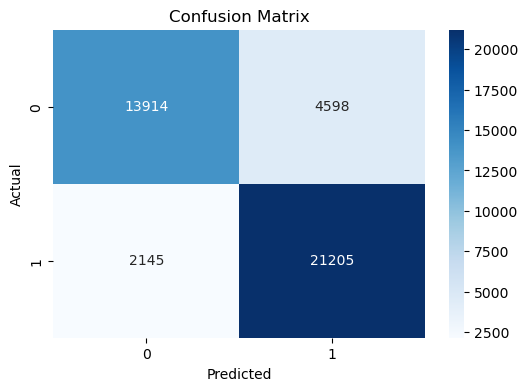

In [ ]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


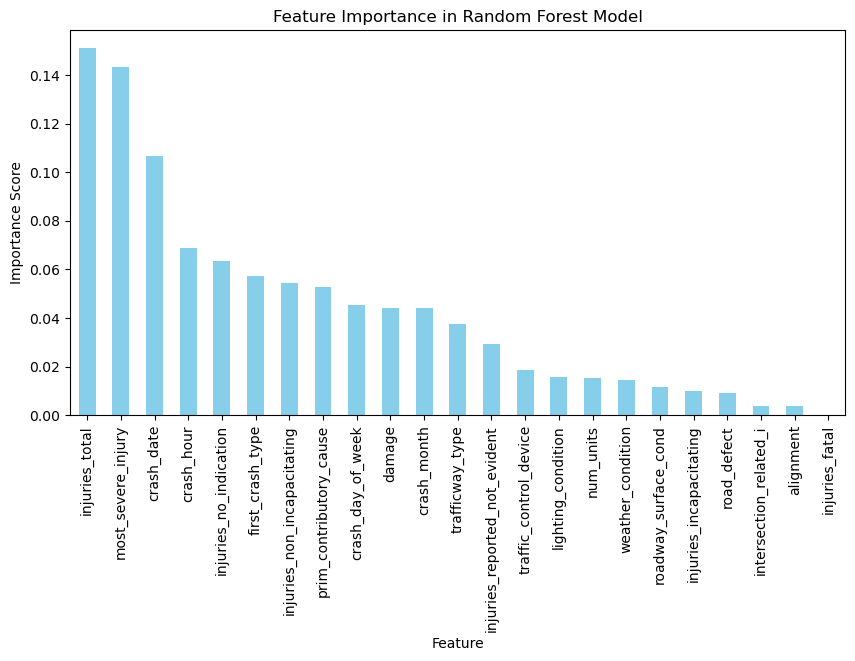

In [ ]:
# Extract feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)

# Sort and plot feature importance
plt.figure(figsize=(10,5))
feature_importance.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance in Random Forest Model')
plt.show()
